In [1]:
import os
import time

import cv2
import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset

import torchvision
import torchvision.transforms as transforms

from PIL import Image
from pympler import tracker
tr = tracker.SummaryTracker()

First, let's organize our data set and display some images

In [2]:
class SiameseDataLoader():
    def __init__(self, data_path, batch_size=16, image_size=100, channel_size=3):
        self.batch_size = batch_size
        self.image_size = image_size
        self.channel_size = channel_size
        
        self.file_paths = []
        self.labels = []
        for root, directories, filenames in os.walk(data_path):
            # Only get images (in subfolders)
            if not root == data_path:
                for filename in filenames:
                    self.file_paths.append(os.path.join(root, filename))
                    self.labels.append(root)
                    
        self.n_samples = len(self.file_paths)
                    
    def get_samples(self):
        random_ordering = np.random.permutation(self.n_samples)
        lower = 0
        upper = self.batch_size
        
        while lower < self.n_samples:
            curr_batch_size = min(self.batch_size, self.n_samples - lower)
            # BCHW
            anchors = np.zeros((curr_batch_size, self.channel_size, self.image_size, self.image_size))
            positives = np.zeros((curr_batch_size, self.channel_size, self.image_size, self.image_size))
            negatives = np.zeros((curr_batch_size, self.channel_size, self.image_size, self.image_size))
            
            for i, anchor in enumerate(random_ordering[lower:upper]):
                # Get a positive sample (sample with same label as anchor)
                positive = np.random.choice(self.n_samples)
                while self.labels[positive] != self.labels[anchor]:
                    positive = np.random.choice(self.n_samples)
                
                # Get a negative sample (sample with different label from anchor)
                negative = np.random.choice(self.n_samples)
                while self.labels[negative] == self.labels[anchor]:
                    negative = np.random.choice(self.n_samples)

                anchors[i,:,:,:] = self.get_image(self.file_paths[anchor]).transpose((2, 0, 1))
                positives[i,:,:,:] = self.get_image(self.file_paths[positive]).transpose((2, 0, 1))
                negatives[i,:,:,:] = self.get_image(self.file_paths[negative]).transpose((2, 0, 1))
            
            # Move to the next batch
            lower, upper = upper, upper + self.batch_size
            
            yield anchors, positives, negatives
            
    def get_image(self, file_path):
        image = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)
        
        h, w = image.shape[0], image.shape[1]
        
        s = min(h, w)
        h_mid = h // 2
        w_mid = w // 2
        margin = s // 2
        
        image = image[h_mid - margin:h_mid + margin, w_mid - margin:w_mid + margin]
        
        return cv2.resize(image, (self.image_size, self.image_size))

In [3]:
train_path = './training'
valid_path = './validation'

train_dataset = SiameseDataLoader(train_path, batch_size=4)
valid_dataset = SiameseDataLoader(valid_path, batch_size=4)

In [4]:
tr.print_diff()

                          types |   # objects |   total size
=============================== | =========== | ============
                   <class 'list |       13974 |      1.34 MB
                    <class 'str |       17748 |      1.29 MB
                    <class 'int |        3022 |     82.64 KB
                   <class 'dict |          37 |     20.52 KB
                  <class 'tuple |          27 |      1.76 KB
                   <class 'type |           1 |      1.37 KB
                   <class 'code |           8 |      1.13 KB
                <class 'weakref |          12 |    960     B
            function (<lambda>) |           6 |    816     B
                    <class 'set |           1 |    736     B
                   <class 'cell |          13 |    624     B
        function (null_wrapper) |           4 |    544     B
  <class 'asyncio.events.Handle |           4 |    384     B
      <class 'functools.partial |           4 |    320     B
                  <class

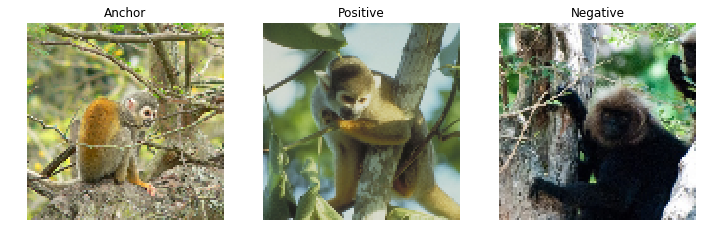

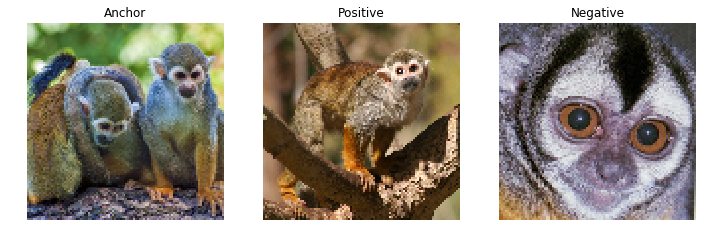

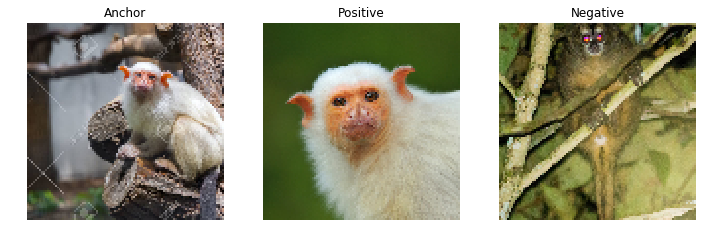

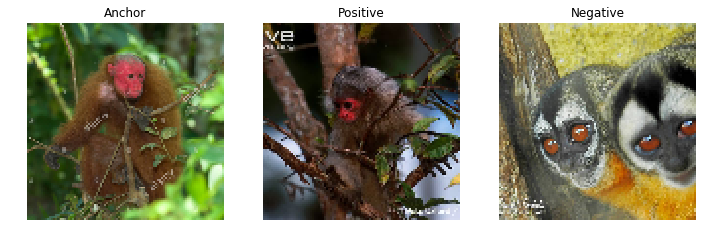

In [5]:
anchors, positives, negatives = next(train_dataset.get_samples())

for i in range(anchors.shape[0]):
    plt.figure(figsize=(12,8))
    plt.subplot(1, 3, 1)
    plt.imshow(anchors[i].transpose((1, 2, 0)).astype(int))
    plt.title("Anchor")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(positives[i].transpose((1, 2, 0)).astype(int))
    plt.title("Positive")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(negatives[i].transpose((1, 2, 0)).astype(int))
    plt.title("Negative")
    plt.axis('off')
    plt.show()

In [6]:
tr.print_diff()

                               types |   # objects |   total size
==================================== | =========== | ============
               <class 'numpy.ndarray |         153 |      2.76 MB
                        <class 'type |           3 |     22.63 KB
                        <class 'dict |          83 |     16.70 KB
                         <class 'str |         129 |     13.07 KB
                       <class 'tuple |         131 |     12.38 KB
                        <class 'list |          83 |      8.27 KB
          <class '_io.BufferedReader |           1 |      4.17 KB
                     <class 'weakref |          50 |      3.91 KB
                        <class 'code |          20 |      2.81 KB
                       <class 'float |         117 |      2.74 KB
  <class 'matplotlib.transforms.Bbox |          50 |      2.73 KB
                       <class 'bytes |          20 |      2.33 KB
    <class 'matplotlib.cbook.maxdict |           0 |      1.99 KB
          

In [7]:
# Now, let's create our Siamese Network

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
         
        self.conv1 = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 8, kernel_size=7, bias=False)
        )

        self.bn1 = nn.BatchNorm2d(8)
        
        self.conv2 = nn.Sequential(
            nn.ReflectionPad2d(2),
            nn.Conv2d(8, 16, kernel_size=5, bias=False)
        )
        self.bn2 = nn.BatchNorm2d(16)
       
        self.conv3 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(16, 32, kernel_size=3, bias=False)
        )
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(32, 64, kernel_size=3, bias=False)
        )
        self.bn4 = nn.BatchNorm2d(64)
        
        
        self.conv5 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 128, kernel_size=3, bias=False)
        )
        self.bn5 = nn.BatchNorm2d(128)
        
        self.conv6 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 256, kernel_size=3, bias=False)
        )
        self.bn6 = nn.BatchNorm2d(256)
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        
        self.fc1 = nn.Sequential(
            nn.Linear(256 * 14 * 14, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 500),
            nn.ReLU(inplace=True)
        )
        
    def forward_once(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)
        
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.bn3(x)
        
        x = self.conv4(x)
        x = self.relu(x)
        x = self.bn4(x)
        
        x = self.maxpool(x)
        
        x = self.conv5(x)
        x = self.relu(x)
        x = self.bn5(x)
        
        x = self.conv6(x)
        x = self.relu(x)
        x = self.bn6(x)
        
        x = self.maxpool(x)
        
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        
        return x        
    
    def forward(self, input1, input2, input3):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)
        
        return output1, output2, output3

In [8]:
class TripletLoss(torch.nn.Module):
    """
    Triplet Loss based on 
    FaceNet https://arxiv.org/pdf/1503.03832.pdf
    """

    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        anchor_positive_dist = F.pairwise_distance(anchor, positive)
        anchor_negative_dist = F.pairwise_distance(anchor, negative)
        loss_triplet = torch.mean(torch.clamp(torch.pow(anchor_positive_dist, 2) - \
                         torch.pow(anchor_negative_dist, 2) + self.margin, min=0.0))

        return loss_triplet

In [9]:
RUN_NAME = "test-6conv2fc;triplet-loss;reflection fix and bias removed"
LEARNING_RATE = 1e-8
N_EPOCHS = 50
WEIGHT_DECAY = 5e-4

siamese_net = SiameseNetwork()
criterion = TripletLoss()
optimizer = optim.Adam(siamese_net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [10]:
tr.print_diff()

                                          types |   # objects |   total size
=============================================== | =========== | ============
                <class 'collections.OrderedDict |         198 |     74.15 KB
                                    <class 'str |         182 |     19.83 KB
                                   <class 'dict |          38 |      7.70 KB
                                   <class 'type |           2 |      4.28 KB
                                   <class 'list |          21 |      3.08 KB
                                  <class 'tuple |          26 |      1.77 KB
           <class 'torch.nn.parameter.Parameter |          22 |      1.55 KB
                           <class 'torch.Tensor |          18 |      1.27 KB
                                   <class 'code |           5 |    720     B
                                <class 'weakref |           8 |    640     B
                        function (null_wrapper) |           4 |    544     B

In [19]:
loss_history = []
for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch}')
    epoch_loss = 0
    for anchors, positives, negatives in train_dataset.get_samples():
        anchor_tensor = Variable(torch.tensor(anchors).type_as(torch.FloatTensor()))
        positive_tensor = Variable(torch.tensor(positives).type_as(torch.FloatTensor()))
        negative_tensor = Variable(torch.tensor(negatives).type_as(torch.FloatTensor()))
        
        output1, output2, output3 = siamese_net(anchor_tensor, positive_tensor, negative_tensor)
        loss_triplet = criterion(output1, output2, output3)
        loss_triplet.backward()
        optimizer.step()

        epoch_loss += loss_triplet.item() * anchor_tensor.shape[0]
    tr.print_diff()
    epoch_loss = epoch_loss / train_dataset.n_samples
    print(f'Epoch loss: {epoch_loss}')
    loss_history.append(epoch_loss)

Epoch: 0
                        types |   # objects |   total size
============================= | =========== | ============
                 <class 'dict |         115 |     14.15 KB
                  <class 'str |          69 |      9.85 KB
            <class '_ast.Name |          50 |      2.73 KB
                 <class 'list |          37 |      2.70 KB
                  <class 'set |           0 |      1.50 KB
            <class '_ast.Call |          22 |      1.20 KB
       <class '_ast.Attribute |          16 |    896     B
                <class 'bytes |          -3 |    471     B
          <class '_ast.Assign |           8 |    448     B
              <class 'weakref |           4 |    320     B
            <class '_ast.Expr |           5 |    280     B
             <class '_ast.Num |           2 |    112     B
           <class '_ast.BinOp |           2 |    112     B
  <class '_ast.FormattedValue |           2 |    112     B
             <class '_ast.For |           2 |  

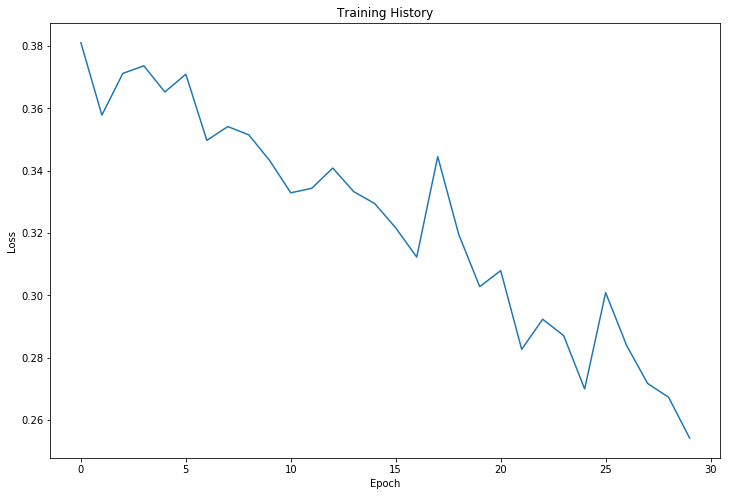

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(list(range(len(loss_history))), loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.show()

In [21]:
with open("log.txt", "a+") as f:
    f.write(f'{RUN_NAME}, {LEARNING_RATE}, {N_EPOCHS}, {WEIGHT_DECAY}, {loss_history}\n')

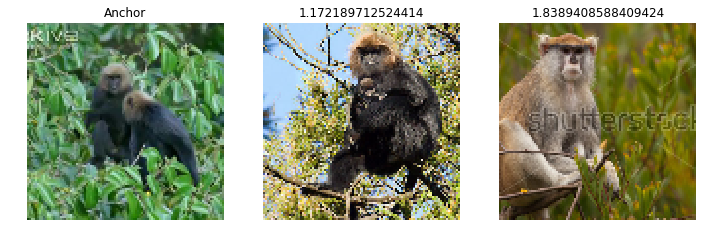

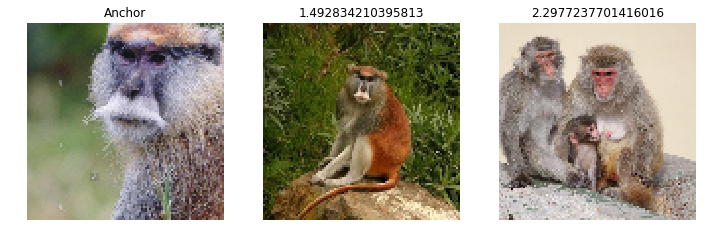

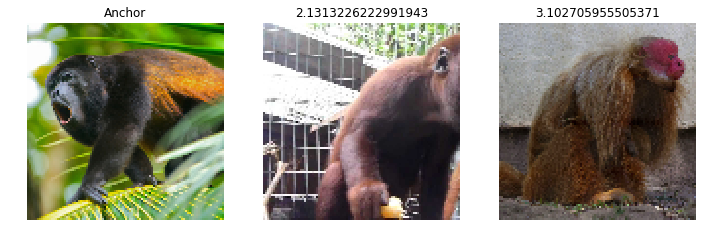

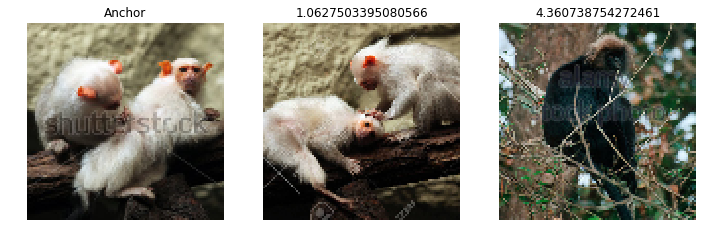

In [22]:
anchors, positives, negatives =  next(train_dataset.get_samples())

anchor_tensor = Variable(torch.tensor(anchors).type_as(torch.FloatTensor()))
positive_tensor = Variable(torch.tensor(positives).type_as(torch.FloatTensor()))
negative_tensor = Variable(torch.tensor(negatives).type_as(torch.FloatTensor()))

output1, output2, output3 = siamese_net(anchor_tensor, positive_tensor, negative_tensor)
anchor_positive_dist = F.pairwise_distance(output1, output2)
anchor_negative_dist = F.pairwise_distance(output1, output3)

for i in range(anchor_tensor.shape[0]):
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(anchors[i].transpose(1, 2, 0).astype(int))
    plt.axis('off')
    plt.title('Anchor')

    plt.subplot(1, 3, 2)
    plt.imshow(positives[i].transpose(1, 2, 0).astype(int))
    plt.axis('off')
    plt.title(f'{torch.pow(anchor_positive_dist[i], 2)}')
    
    plt.subplot(1, 3, 3)
    plt.imshow(negatives[i].transpose(1, 2, 0).astype(int))
    plt.axis('off')
    plt.title(f'{torch.pow(anchor_negative_dist[i], 2)}')
    
    plt.show()

In [23]:
tr.print_diff()

                                      types |   # objects |   total size
=========================================== | =========== | ============
                      <class 'numpy.ndarray |           0 |      1.37 MB
                                <class 'str |          26 |      5.22 KB
                              <class 'tuple |          20 |      1.29 KB
                            <class 'weakref |           4 |    320     B
                              <class 'bytes |          10 |    271     B
                      <class 'list_iterator |           3 |    168     B
                               <class 'code |           1 |    144     B
         <class 'builtin_function_or_method |           2 |    144     B
                               <class 'cell |           3 |    144     B
                        function (<lambda>) |           1 |    136     B
                             <class 'method |           2 |    128     B
                     <class 'sqlite3.Cursor |      

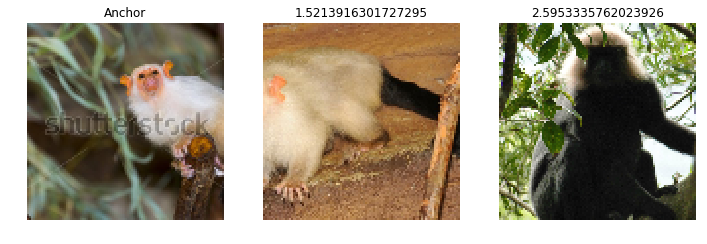

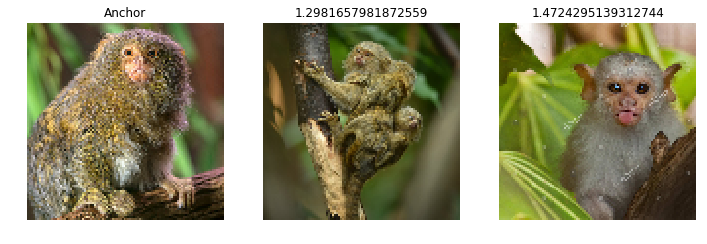

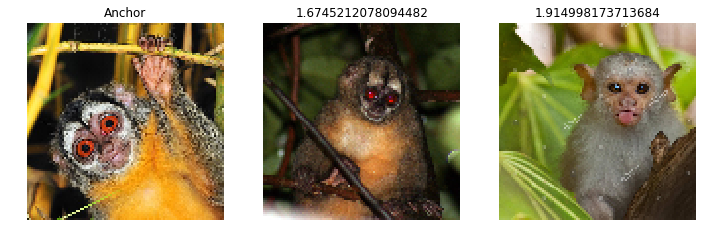

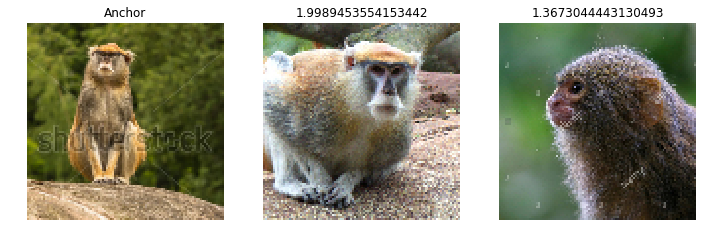

In [24]:
anchors, positives, negatives =  next(valid_dataset.get_samples())

anchor_tensor = Variable(torch.tensor(anchors).type_as(torch.FloatTensor()))
positive_tensor = Variable(torch.tensor(positives).type_as(torch.FloatTensor()))
negative_tensor = Variable(torch.tensor(negatives).type_as(torch.FloatTensor()))

output1, output2, output3 = siamese_net(anchor_tensor, positive_tensor, negative_tensor)
anchor_positive_dist = F.pairwise_distance(output1, output2)
anchor_negative_dist = F.pairwise_distance(output1, output3)

for i in range(anchor_tensor.shape[0]):
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(anchors[i].transpose(1, 2, 0).astype(int))
    plt.axis('off')
    plt.title('Anchor')

    plt.subplot(1, 3, 2)
    plt.imshow(positives[i].transpose(1, 2, 0).astype(int))
    plt.axis('off')
    plt.title(f'{torch.pow(anchor_positive_dist[i], 2)}')
    
    plt.subplot(1, 3, 3)
    plt.imshow(negatives[i].transpose(1, 2, 0).astype(int))
    plt.axis('off')
    plt.title(f'{torch.pow(anchor_negative_dist[i], 2)}')
    
    plt.show()

In [26]:
for parameter in siamese_net.parameters():
    print(f"{parameter.shape}  -- requires grad: {parameter.requires_grad}")
#     print(f"{parameter.grad}")

torch.Size([8, 3, 7, 7])  -- requires grad: True
torch.Size([8])  -- requires grad: True
torch.Size([8])  -- requires grad: True
torch.Size([16, 8, 5, 5])  -- requires grad: True
torch.Size([16])  -- requires grad: True
torch.Size([16])  -- requires grad: True
torch.Size([32, 16, 3, 3])  -- requires grad: True
torch.Size([32])  -- requires grad: True
torch.Size([32])  -- requires grad: True
torch.Size([64, 32, 3, 3])  -- requires grad: True
torch.Size([64])  -- requires grad: True
torch.Size([64])  -- requires grad: True
torch.Size([128, 64, 3, 3])  -- requires grad: True
torch.Size([128])  -- requires grad: True
torch.Size([128])  -- requires grad: True
torch.Size([256, 128, 3, 3])  -- requires grad: True
torch.Size([256])  -- requires grad: True
torch.Size([256])  -- requires grad: True
torch.Size([500, 50176])  -- requires grad: True
torch.Size([500])  -- requires grad: True
torch.Size([500, 500])  -- requires grad: True
torch.Size([500])  -- requires grad: True
